In [ ]:
# Import necessary libraries
import torch
import torchvision.models as models
import torch.nn as nn

from google.colab import drive

drive.mount('/content/drive')

import numpy as np
from os import listdir

import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt



# hyperparameter set

# through experimenting to see which hyperparameters have the largest effect, 
# we decided that the hyperparameters we will tune are:

# learning rate
# dropout probability
# depth of second regressor fc layer
# weight decay coefficient



# the current set of hyperparameters
# running all subsequent codeblocks will test these hyperparameters, graph, and save the model
hyper = [0.001, 0.25, [2048, 2048], 0.1, 24, 50]


# the randomization code was moved to another file temporarily to simplify things 
# so i can do manual hyperparameter testing for now



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = models.vgg16(pretrained=True)

# define loss
loss_function = torch.nn.MSELoss()


class FolderDataset():
    def __init__(self, folder):
        self.files = listdir(folder)
        self.folder = folder

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        return torch.load(f"{self.folder}/{self.files[idx]}")


train_folder_data = FolderDataset("/content/drive/MyDrive/test-validation-train/train_set")

valid_folder_data = FolderDataset("/content/drive/MyDrive/test-validation-train/valid_set")

test_folder_data = FolderDataset("/content/drive/MyDrive/test-validation-train/test_set")

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
'''
for i, param in enumerate(model.parameters()):
    if i < hyper[4]:
        param.requires_grad = False
'''

'''
feats_list = list(model.features)
new_feats_list = []
for feat in feats_list:
    new_feats_list.append(feat)
    if isinstance(feat, nn.Conv2d):
        new_feats_list.append(nn.Dropout(p=0.25, inplace=True))

# modify convolution layers
model.features = nn.Sequential(*new_feats_list)
'''

num_classes = 1  # Assuming scalar labels
model.classifier = nn.Sequential(
    #nn.Dropout(p=hyper[1], inplace=True),
    nn.Linear(25088, hyper[2][0]),  # Example FC layer 1
    nn.ReLU(inplace=True),
    nn.Dropout(p=hyper[1]),
    nn.Linear(hyper[2][0], hyper[2][1]),  # Example FC layer 3
    nn.ReLU(inplace=True),
    nn.Dropout(p=hyper[1]),
    nn.Linear(hyper[2][1], num_classes)  # Example output layer
)


#optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=hyper[0], weight_decay=hyper[3])
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=hyper[0], weight_decay=hyper[3])


# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU
model = model.to(device)

# Initialize a list to store the loss values
loss_values = []
valid_loss = []

overall_epoch_loss_train = []
overall_epoch_loss_valid = []

num_epochs = hyper[5]


'\nfeats_list = list(model.features)\nnew_feats_list = []\nfor feat in feats_list:\n    new_feats_list.append(feat)\n    if isinstance(feat, nn.Conv2d):\n        new_feats_list.append(nn.Dropout(p=0.25, inplace=True))\n\n# modify convolution layers\nmodel.features = nn.Sequential(*new_feats_list)\n'

In [ ]:

# Fine-tune the model on your own regression problem
for epoch in range(num_epochs):  # Number of epochs

    # loss for each epoch
    epoch_loss = 0
    epoch_valid_loss = 0

    model.train()

    # Wrap the dataloader loop with tqdm for a progress bar
    for i in tqdm(range(train_folder_data.__len__()), desc=f"Epoch {epoch + 1}/{num_epochs}"):
        # Get input and target from the batch
        inputs, targets = train_folder_data.__getitem__(i)

        # Convert targets to Float data type and add an extra dimension
        targets = targets.float().unsqueeze(1)

        # Move input and target tensors to the GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = loss_function(outputs, targets)

        loss_values.append(loss.item())
        epoch_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # inputs, targets = inputs.cpu(), targets.cpu()

        # Update the model parameters
        optimizer.step()

        loss.cpu()
        inputs.cpu()
        targets.cpu()
        outputs.cpu()
        del loss
        del inputs
        del targets
        del outputs
        torch.cuda.empty_cache()

    print(epoch_loss / train_folder_data.__len__())
    overall_epoch_loss_train.append(epoch_loss / train_folder_data.__len__())

    del epoch_loss

    model.eval()

    # Iterate over the dataloader
    for i in tqdm(range(valid_folder_data.__len__()), desc=f"Eval Epoch {epoch + 1}/{num_epochs}"):
        # Get the input data and move it to the GPU
        inputs, targets = valid_folder_data.__getitem__(i)
        targets = targets.float().unsqueeze(1)

        inputs, targets = inputs.to(device), targets.to(device)

        # Pass the input data through the model and get the predicted output
        outputs = model(inputs)

        loss = loss_function(outputs, targets)

        valid_loss.append(loss.item())
        epoch_valid_loss += loss.item()

        # inputs, targets = inputs.cpu(), targets.cpu()

        loss.cpu()
        inputs.cpu()
        targets.cpu()
        outputs.cpu()
        del loss
        del inputs
        del targets
        del outputs

        torch.cuda.empty_cache()

    print(epoch_valid_loss / valid_folder_data.__len__())
    overall_epoch_loss_valid.append(epoch_valid_loss / valid_folder_data.__len__())

    del epoch_valid_loss

# Plot the training loss curve
plt.figure()
plt.plot(np.linspace(1, len(loss_values), len(loss_values)), np.sqrt(loss_values))
plt.plot(np.linspace(1, len(loss_values), len(valid_loss)), np.sqrt(valid_loss))
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.ylim(0, 5)
plt.title('Training Loss Curve')

plt.legend(['Training loss', 'Validation loss'])

plt.show()

# Plot the training loss curve
plt.figure()
plt.plot(np.sqrt(overall_epoch_loss_train))
plt.plot(np.sqrt(overall_epoch_loss_valid))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 5)
plt.title('Training Loss Curve')

plt.legend(['Training loss', 'Validation loss'])

plt.show()


Epoch 1/50: 100%|██████████| 151/151 [00:40<00:00,  3.77it/s]


0.600308043919257


Eval Epoch 1/50: 100%|██████████| 19/19 [00:01<00:00, 10.77it/s]


1.289395465662605


Epoch 2/50: 100%|██████████| 151/151 [00:39<00:00,  3.85it/s]


0.6160362203981703


Eval Epoch 2/50: 100%|██████████| 19/19 [00:01<00:00, 10.79it/s]


1.4570645595851697


Epoch 3/50: 100%|██████████| 151/151 [00:39<00:00,  3.80it/s]


0.5950658065297746


Eval Epoch 3/50: 100%|██████████| 19/19 [00:01<00:00, 10.69it/s]


1.267721550245034


Epoch 4/50: 100%|██████████| 151/151 [00:39<00:00,  3.84it/s]


0.6313178676445752


Eval Epoch 4/50: 100%|██████████| 19/19 [00:01<00:00, 10.75it/s]


1.5005032169191461


Epoch 5/50: 100%|██████████| 151/151 [00:39<00:00,  3.83it/s]


0.6113051801722571


Eval Epoch 5/50: 100%|██████████| 19/19 [00:01<00:00, 10.59it/s]


1.4719546750972146


Epoch 6/50: 100%|██████████| 151/151 [00:39<00:00,  3.82it/s]


0.627333081814627


Eval Epoch 6/50: 100%|██████████| 19/19 [00:01<00:00, 10.14it/s]


1.6034654253407528


Epoch 7/50: 100%|██████████| 151/151 [00:39<00:00,  3.83it/s]


0.640778783437432


Eval Epoch 7/50: 100%|██████████| 19/19 [00:01<00:00,  9.89it/s]


1.323642451512186


Epoch 8/50: 100%|██████████| 151/151 [00:39<00:00,  3.84it/s]


0.6584687560599372


Eval Epoch 8/50: 100%|██████████| 19/19 [00:01<00:00,  9.80it/s]


1.4297860343205302


Epoch 9/50: 100%|██████████| 151/151 [00:39<00:00,  3.82it/s]


0.5946611434418634


Eval Epoch 9/50: 100%|██████████| 19/19 [00:01<00:00, 10.35it/s]


1.4022004243574644


Epoch 10/50: 100%|██████████| 151/151 [00:39<00:00,  3.83it/s]


0.6298860161509735


Eval Epoch 10/50: 100%|██████████| 19/19 [00:01<00:00, 10.73it/s]


1.3173924637468237


Epoch 11/50: 100%|██████████| 151/151 [00:39<00:00,  3.82it/s]


0.5265229129238634


Eval Epoch 11/50: 100%|██████████| 19/19 [00:01<00:00, 10.71it/s]


1.4725507560529207


Epoch 12/50: 100%|██████████| 151/151 [00:39<00:00,  3.83it/s]


0.5970996438667474


Eval Epoch 12/50: 100%|██████████| 19/19 [00:01<00:00, 10.76it/s]


1.2187541629138745


Epoch 13/50: 100%|██████████| 151/151 [00:39<00:00,  3.84it/s]


0.6119126837379885


Eval Epoch 13/50: 100%|██████████| 19/19 [00:01<00:00, 10.69it/s]


1.58985393925717


Epoch 14/50: 100%|██████████| 151/151 [00:39<00:00,  3.84it/s]


0.7097699368828969


Eval Epoch 14/50: 100%|██████████| 19/19 [00:01<00:00, 10.77it/s]


1.2875351152921979


Epoch 15/50: 100%|██████████| 151/151 [00:39<00:00,  3.82it/s]


0.7320581321289997


Eval Epoch 15/50: 100%|██████████| 19/19 [00:01<00:00, 10.69it/s]


1.8010708752431368


Epoch 16/50: 100%|██████████| 151/151 [00:39<00:00,  3.84it/s]


0.6498104090130092


Eval Epoch 16/50: 100%|██████████| 19/19 [00:01<00:00, 10.73it/s]


1.4524228761070652


Epoch 17/50: 100%|██████████| 151/151 [00:39<00:00,  3.83it/s]


0.5944877283659992


Eval Epoch 17/50: 100%|██████████| 19/19 [00:01<00:00, 10.74it/s]


1.4381319221697355


Epoch 18/50: 100%|██████████| 151/151 [00:39<00:00,  3.82it/s]


0.5833530630299587


Eval Epoch 18/50: 100%|██████████| 19/19 [00:01<00:00, 10.55it/s]


1.287472884121694


Epoch 19/50: 100%|██████████| 151/151 [00:39<00:00,  3.82it/s]


0.638250293123801


Eval Epoch 19/50: 100%|██████████| 19/19 [00:01<00:00, 10.28it/s]


1.7192923332515515


Epoch 20/50: 100%|██████████| 151/151 [00:39<00:00,  3.83it/s]


0.658657885051721


Eval Epoch 20/50: 100%|██████████| 19/19 [00:01<00:00,  9.94it/s]


1.6155154956014532


Epoch 21/50: 100%|██████████| 151/151 [00:39<00:00,  3.83it/s]


0.6537456195678143


Eval Epoch 21/50: 100%|██████████| 19/19 [00:01<00:00,  9.93it/s]


1.3264795196683783


Epoch 22/50: 100%|██████████| 151/151 [00:39<00:00,  3.83it/s]


0.5925206150736241


Eval Epoch 22/50: 100%|██████████| 19/19 [00:01<00:00, 10.38it/s]


1.3000914642685337


Epoch 23/50: 100%|██████████| 151/151 [00:39<00:00,  3.82it/s]


0.618774614882785


Eval Epoch 23/50: 100%|██████████| 19/19 [00:01<00:00, 10.66it/s]


1.7174852176716453


Epoch 24/50: 100%|██████████| 151/151 [00:39<00:00,  3.82it/s]


0.6037222599943742


Eval Epoch 24/50: 100%|██████████| 19/19 [00:01<00:00, 10.79it/s]


1.2250729407134808


Epoch 25/50: 100%|██████████| 151/151 [00:39<00:00,  3.82it/s]


0.6143224017312195


Eval Epoch 25/50: 100%|██████████| 19/19 [00:01<00:00, 10.78it/s]


1.2700371977530027


Epoch 26/50: 100%|██████████| 151/151 [00:39<00:00,  3.83it/s]


0.6328072905145734


Eval Epoch 26/50: 100%|██████████| 19/19 [00:01<00:00, 10.62it/s]


1.3640510784952264


Epoch 27/50: 100%|██████████| 151/151 [00:39<00:00,  3.82it/s]


0.628317159434028


Eval Epoch 27/50: 100%|██████████| 19/19 [00:01<00:00, 10.65it/s]


2.402031685176649


Epoch 28/50: 100%|██████████| 151/151 [00:39<00:00,  3.82it/s]


0.6228358674523057


Eval Epoch 28/50: 100%|██████████| 19/19 [00:01<00:00, 10.82it/s]


1.3751189755766016


Epoch 29/50: 100%|██████████| 151/151 [00:39<00:00,  3.83it/s]


0.5790922005247596


Eval Epoch 29/50: 100%|██████████| 19/19 [00:01<00:00, 10.76it/s]


1.2948021371113627


Epoch 30/50: 100%|██████████| 151/151 [00:39<00:00,  3.83it/s]


0.5751660650731713


Eval Epoch 30/50: 100%|██████████| 19/19 [00:01<00:00, 10.74it/s]


1.3175760178189528


Epoch 31/50:  29%|██▉       | 44/151 [00:11<00:28,  3.72it/s]


KeyboardInterrupt: ignored

<function matplotlib.pyplot.show(close=None, block=None)>

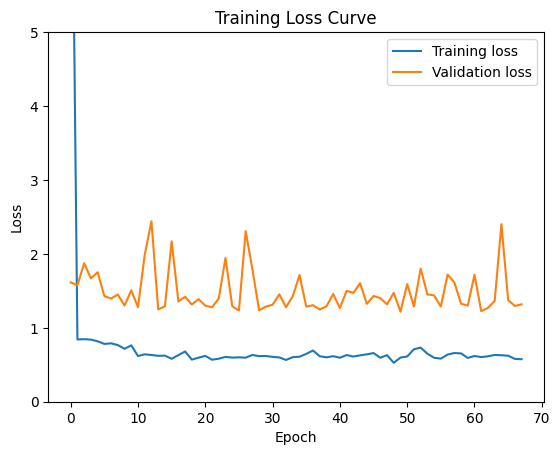

In [ ]:
# Plot the training loss curve
plt.figure()
plt.plot((overall_epoch_loss_train))
plt.plot((overall_epoch_loss_valid))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 5)
plt.title('Training Loss Curve')

plt.legend(['Training loss', 'Validation loss'])

plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

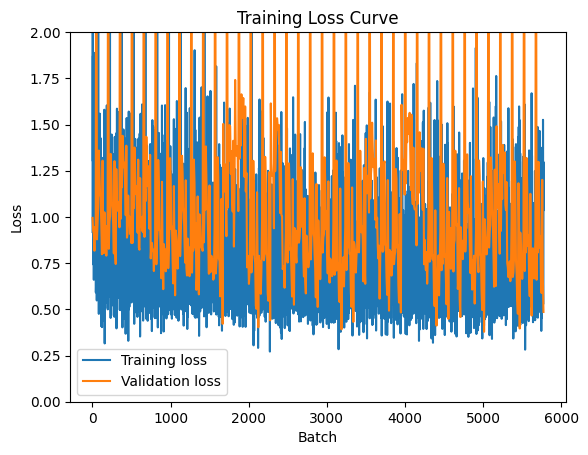

In [ ]:
# Plot the training loss curve
plt.plot(np.linspace(1, len(loss_values), len(loss_values)), np.sqrt(loss_values))
plt.plot(np.linspace(1, len(loss_values), len(valid_loss)), np.sqrt(valid_loss))
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.ylim(0, 2)
plt.title('Training Loss Curve')

plt.legend(['Training loss', 'Validation loss'])

plt.show

In [ ]:
for i, param in enumerate(model.parameters()):
    print(i, param.size())

In [ ]:
model.eval()

test_loss = 0

# Iterate over the dataloader
for i in tqdm(range(test_folder_data.__len__())):
    # Get the input data and move it to the GPU
    inputs, targets = test_folder_data.__getitem__(i)
    targets = targets.float().unsqueeze(1)

    inputs, targets = inputs.to(device), targets.to(device)

    # Pass the input data through the model and get the predicted output
    outputs = model(inputs)

    loss = loss_function(outputs, targets)

    test_loss += loss.item()

    # inputs, targets = inputs.cpu(), targets.cpu()

    loss.cpu()
    inputs.cpu()
    targets.cpu()
    outputs.cpu()
    del loss
    del inputs
    del targets
    del outputs

    torch.cuda.empty_cache()

print(test_loss / test_folder_data.__len__())



100%|██████████| 19/19 [00:24<00:00,  1.31s/it]

0.9998356856797871


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/test-validation-train/CNN.pt")